<a href="https://colab.research.google.com/github/szkudlarekdamian/florida-ecosystem-analysis/blob/main/florida_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wymagania

## Projekt za 50 pkt.
Przygotuj krótki opis interesującego problemu, który może zostać rozwiązany przy pomocy metod analizy i eksploracji sieci. Sformułuj dwa pytania o charakterze biznesowym, na które odpowiedź stanowić będzie wynik przeprowadzonej analizy. Postaraj się znaleźć właściwy zbiór danych w publicznie dostępnych repozytoriach. Jeśli takiego zbioru nie znajdziesz, postaraj się dokonać akwizycji potrzebnych danych.

W ramach analizy przedstaw podstawowe charakterystyki analizowanego zbioru danych:

* rozkład stopni wyjściowych i wejściowych
* rozkład długości najkrótszych ścieżek
* rozkład pośrednictwa
* rozkład lokalnych współczynników grupowania
* miary oceny sieci: gęstość, współczynnik centralizacji, promień
* podział sieci na moduły

Przygotuj także trzy wizualizacje analizowanej sieci. W swoich wizualizacjach kieruj się zasadami storytelling ( https://www.import.io/post/8-fantastic-examples-of-data-storytelling/, https://www.analyticsvidhya.com/blog/2017/10/art-story-telling-data-science/ )

Dodatkowe wymagania

* analiza musi być wykonana tylko i wyłącznie przy użyciu bibliotek programistycznych (iGraph/R, NetworkX/Python, JGraphT GraphStream/Java)
* analiza musi być w pełni reprodukowalna (np. nie można korzystać z lokalnych kopii zbiorów danych, zbiory danych muszą być pobierane programistycznie)
* wynik analizy musi być przedstawiony przy użyciu narzędzi literate programming (RMarkdown, Jupyter Notebooks, Apache Zeppelin)

# Trophic Dynamics in South Florida Ecosystems

Damian Szkudlarek 131836, Wojciech Taisner 132330

Źródło danych: [Pajek data](http://vlado.fmf.uni-lj.si/pub/networks/data/bio/foodweb/foodweb.htm), [artykuł](https://www.researchgate.net/publication/227229222_Unexpected_Effects_of_Predators_Upon_Their_Prey_The_Case_of_the_American_Alligator)

## Opis grafu
Wybrany graf obrazuje naturalnie zachodzącą w naturze wymianę węgla (energii) między elementami ekosystemu rezerwatu narodowego Stanów Zjednoczonych położonego w południowej Florydzie - **Big Cypress National Preserve**.

Obserwacje zostały zanotowane w porze suchej (od grudnia do maja), gdy poziomy wody są stosunkowo niskie, a sklepienia drzew skąpe.

Wierzchołki reprezentują ważne elementy ekosystemu, ważone krawędzie reprezentują przekazywanie energii między tymi elementami. Poprzez element najczęściej należy rozumieć grupę organizmów (np. małe ryby roślinnożerne lub wszystkożerne) lub pojedyncze organizmy (np. opos). W dalszej części dokumentu, wierzchołki nazywane będą również segmentami środowiska naturalnego.

Waga krawędzi jest zależna od ogromu transferu energii w uśrednieniu przez określony okres czasu.

Ta sieć przepływu troficznego jest graficzną i matematyczną reprezentacją odpowiedzi na pytania "Kto zjada kogo i w jakim stopniu?"

## Pozostałe przydatne informacje:

>Detrytus, detryt – drobnoszczątkowa, martwa materia organiczna, martwe szczątki roślin, zwierząt oraz ich odchodów występujące na powierzchni gleby, na dnie zbiorników wodnych lub unoszące się w toni wodnej.

>Particulate organic carbon (POC) - operacyjnie definiuje się tak każdy palny, niewęglanowy węgiel, który da się zebrać filtrem. Obok niego znajdować może się biomasa żyjących komórek mikrobiologicznych.

>Understory - Podszyt, podszycie lasu – warstwa roślinności w ekosystemie leśnym zbudowana z krzewów i niskich drzew o wysokości do 4 m. 

>Living sediment - żyjący osad - łączy w sobie bakterioplankton, mikrofaunę i mejobentos (organizmy zwierzęce związane z dnem środowisk wodnych).

>Refractory detritus - segment reprezentujący materię organiczną, która rozkłada się stosunkowo powoli.

>Liable detritus  - segment reprezentujący materię organiczną, która rozkłada się szybciej.

>Vertebrate detritus - segment reprezentujący ciała kręgowców bezpośrednio po śmierci.

>Invertebrate - Bęzkręgowce.

>Anseriformes - Blaszkodziobe (obejmują ptaki wodne, np. kaczki).

>Passeriformes - Wróblowe.

## Przygotowanie środowiska

Poniżej przedstawionych jest kilka kroków niezbędnych do przygotowania środowiska i wczytania grafu.

## Pobranie danych

In [ ]:
%%sh
mkdir -p data
wget -q http://vlado.fmf.uni-lj.si/pub/networks/data/bio/foodweb/cypdry.paj -O data/cypdry.paj

## Wczytanie bibliotek

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx

from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# networkx version
nx.__version__

'2.5.1'

## Odczyt i przetworzenie danych źródłowych

Ze względu na niepoprawne formatowanie pliku (pojedyncze cyfry występujące na początku), należy je usunąć, by móc załadować dane do grafu.

In [ ]:
from os import walk
_, _, filenames = next(walk("data"))
for filename in filenames:
  with open("data/"+filename,"r+") as f:
    new_f = f.readlines()
    f.seek(0)
    for line in new_f:
      if len(line) > 2:
        f.write(line)
    f.truncate()

In [ ]:
BD = nx.DiGraph(nx.read_pajek("data/cypdry.paj"))

In [ ]:
# usunięcie zbędnych wierzchołków
BD.remove_nodes_from(['cypdry.dat','71','70', '*vector', 'bio-masses', 'Input'])

In [ ]:
print(nx.info(BD))

Name: 
Type: DiGraph
Number of nodes: 68
Number of edges: 554
Average in degree:   8.1471
Average out degree:   8.1471


## Przegląd danych

Niniejsza sekcja zawiera krótki przegląd danych w postaci listy krawędzi.

Dla przypomnienia krotka ma postać *(Producent, Konsument, {ogrom energii})*

In [ ]:
# krawędzie
sorted(BD.edges.data(), key=lambda x: x[2]['weight'], reverse=True)[:10]

[('Liable Det.', 'Living sediment', {'weight': 188.0}),
 ('Understory', 'Refractory Det.', {'weight': 97.5}),
 ('Phytoplankton', 'Liable Det.', {'weight': 81.1}),
 ('Hardwoods Leaves', 'Refractory Det.', {'weight': 54.6}),
 ('Macrophytes', 'Refractory Det.', {'weight': 45.5}),
 ('Float. vegetation', 'Refractory Det.', {'weight': 44.1}),
 ('Refractory Det.', 'Living sediment', {'weight': 40.6}),
 ('Living sediment', 'Liable Det.', {'weight': 37.4}),
 ('Cypress Leaves', 'Refractory Det.', {'weight': 31.7}),
 ('Periphyton/Macroalgae', 'Living sediment', {'weight': 28.1})]

Poniższy wykres przedstawia rozkład wag krawędzi. Większość krawędzi w grafie ma bardzo małe (możnaby stwierdzić że pomijalne) wartości wag.

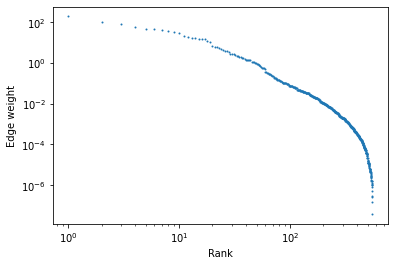

In [ ]:
weights = [x[2]['weight'] for x in BD.edges.data()]
plt.loglog(range(1, BD.number_of_edges()+1), sorted(weights, reverse=True), '.', markersize=2)
plt.xlabel('Rank')
plt.ylabel('Edge weight')
plt.show()

## Alternatywne wersje grafu

Dla celów dodatkowych analiz, przygotowano dwie *dodatkowe* wersje grafu.

V1 - w tej wersji z grafu usunięto wszystkie krawędzie o wadze mniejszej niż 0.01.

In [ ]:
# removeing edges with minimal weight
edges_to_remove = [(u, v) for u, v, d in BD.edges.data() if d['weight'] < .01]
RBDv1 = nx.restricted_view(BD, nodes=[], edges=edges_to_remove)
RBDv1.number_of_nodes(), RBDv1.number_of_edges()

(68, 202)

V2 - w tej wersji postanowiono "przerwać" łańcuch pokarmowy poprzez usunięcie wierzchołków reprezentujących szczątki roślinne i zwierzęce.

In [ ]:
# No detritus
detritus = [n for n in BD.nodes() if n.endswith('Det.') or n.endswith('POC')]
RBDv2 = nx.restricted_view(BD, nodes=detritus, edges=[])
RBDv2.number_of_nodes(), RBDv2.number_of_edges()

(64, 439)

# Podstawowa analiza sieci

Niniejsza sekcja poświęcona jest podstawowej analizie sieci.


## Miary oceny sieci

W tej sekcji wyznaczyliśmy podstawowe miary oceny sieci.

Gęstość


In [ ]:
# gęstość
nx.density(BD)

0.12159789288849868

Współczynnik centralności według stopnia, bliskości i pośredniości

In [ ]:
# współczynnik centralności wg stopnia
np.mean(list(nx.degree_centrality(BD).values()))

0.24319578577699735

In [ ]:
# współczynnik centralności wg bliskości
np.mean(list(nx.closeness_centrality(BD).values()))

0.33666484938441216

In [ ]:
# współczynnik centralności wg pośredniości
np.mean(list(nx.betweenness_centrality(BD).values()))

0.01649173916513688

Współczynnik centralizacji 

In [ ]:
def freeman_centralization(values: list) -> float:
  """
  for in- and out- degree centrality
  """
  max_value = max(values)
  denominator = len(values) - 1 # maximal sum of differences (star graph)
  return np.sum(np.ones(len(values)) * max_value - np.array(values)) / denominator


stopni wejściowych

In [ ]:
freeman_centralization(list(nx.in_degree_centrality(BD).values()))

0.5734016484740477

i stopni wyjściowych.

In [ ]:
freeman_centralization(list(nx.out_degree_centrality(BD).values()))

0.4673646691913566

Promień i średnica sieci

In [ ]:
# średnica
try:
  print(nx.diameter(BD))
except nx.NetworkXError as e:
  print(e)

Found infinite path length because the digraph is not strongly connected


In [ ]:
# promień
try:
  print(nx.radius(BD))
except nx.NetworkXError as e:
  print(e)

Found infinite path length because the digraph is not strongly connected


Nie można wyznaczyć promienia i średnicy grafu, dlatego że nie jest silnie spójny.

W tej sytuacji wyznaczone zostaną wartości tych miar dla największego spójnego komponentu. Zawiera on 53 wierzchołki, wszystkie pozostałe wierzchołki grafu są kompontentami jednostkowymi.

In [ ]:
biggus = max(nx.strongly_connected_components(BD), key=len)
print('Średnica', nx.diameter(BD.subgraph(biggus)))
print('Promień ', nx.radius(BD.subgraph(biggus)))

Średnica 4
Promień  3


W związku z tym, że graf jest dość mały, wyświetlimy go przed dalszą analizą.
Czerwone wierzchołki należą do największego silnie spójnego komponentu.


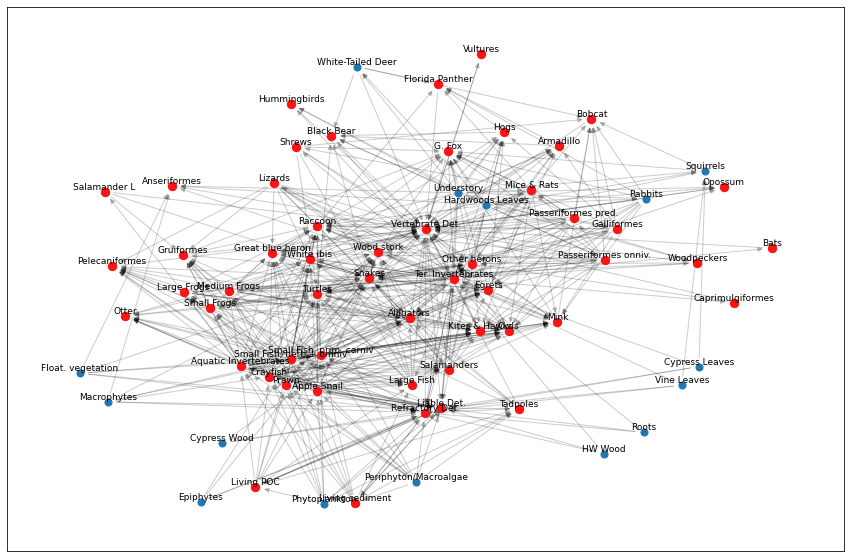

In [ ]:
plt.figure(figsize=(15,10))
pos = nx.nx_pydot.graphviz_layout(BD)
nx.draw_networkx_nodes(BD, pos=pos, node_size=50)
nx.draw_networkx_nodes(BD.subgraph(biggus), pos=pos, node_size=70, node_color="#FF1314")
nx.draw_networkx_edges(BD, pos=pos, alpha=0.2)
nx.draw_networkx_labels(BD, pos=pos, font_size=9, verticalalignment='bottom')
plt.show()

Uzyskana wizualizacja jest w zgodzie z tym, co o sieci mówią nam wyznaczone miary. Wysoka gęstość, niska wartość centralności według pośredniości oraz wysoka wartość centralności według bliskości sugerują, że graf jest jednym, gęsto połączonym komponentem. Taki też widok uzyskaliśmy w wizualizacji.

## Rozkład stopni wyjściowych i wejściowych

W tej sekcji pokrótce przyjrzymy się rozkładowi stopni wejściowych i wyjściowych wierzchołków.

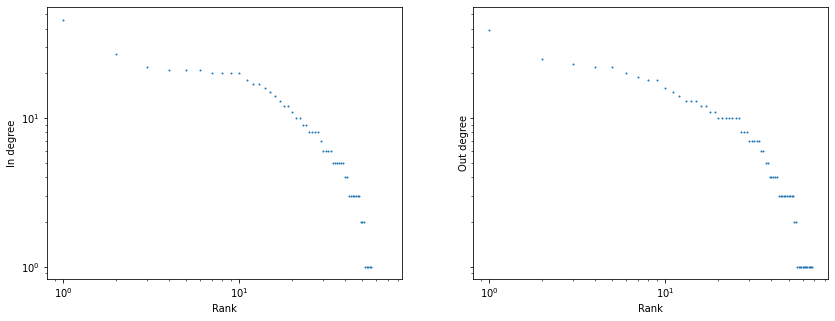

In [ ]:
in_degree_sequence = [d for n, d in BD.in_degree()]
out_degree_sequence = [d for n, d in BD.out_degree()]

fix, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5), sharey=True)

ax1.loglog(range(1,BD.order()+1),sorted(in_degree_sequence,reverse=True),'.', markersize=2)
ax1.set_xlabel('Rank')
ax1.set_ylabel('In degree')

ax2.loglog(range(1,BD.order()+1),sorted(out_degree_sequence,reverse=True),'.', markersize=2)
ax2.set_xlabel('Rank')
ax2.set_ylabel('Out degree')

plt.show()

Wyświetlamy po 10 wierzchołków o najwyższym stopniu wejściowym i wyjściowym.

Duży stopień wejściowy oznacza, że wierzchołek przyjmował energię z wielu źródeł - na pierwszym miejscu plasuje się detryt kręgowców, który w tym zbiorze jest równoważny z transformacją materii kregówców w padlinę 

In [ ]:
deg = dict(BD.in_degree())
sorted(deg.items(), key=lambda i: i[1],reverse=True)[:10] 

[('Vertebrate Det.', 46),
 ('Snakes', 27),
 ('Alligators', 22),
 ('Turtles', 21),
 ('Kites & Hawks', 21),
 ('Raccoon', 21),
 ('Other herons', 20),
 ('Owls', 20),
 ('Refractory Det.', 20),
 ('Liable Det.', 20)]

Duży stopień wyjściowy oznacza, że wierzchołek oddawał energię wielu źródłom. Na pierwszym i drugim miejscu znalazły sie bezkręgowce, kolejno lądowe i wodne


In [ ]:
deg = dict(BD.out_degree())
sorted(deg.items(), key=lambda i: i[1], reverse=True)[:10]

[('Ter. Invertebrates', 39),
 ('Aquatic Invertebrates', 25),
 ('Prawn', 23),
 ('Crayfish', 22),
 ('Apple Snail', 22),
 ('Small Fish, herb + omniv', 20),
 ('Small Fish, prim. carniv', 19),
 ('Understory', 18),
 ('Hardwoods Leaves', 18),
 ('Mice & Rats', 16)]

Biorąc pod uwagę wagę krawędzi, ranking układa sie inaczej, ponieważ nie bierze pod uwagę tylko liczby różnych dostawców energii, lecz także ogrom przyjmowanej energii.

In [ ]:
deg = dict(BD.in_degree(weight='weight'))
sorted(deg.items(), key=lambda i: i[1],reverse=True)[:10] 

[('Refractory Det.', 332.1206),
 ('Living sediment', 256.7),
 ('Liable Det.', 218.89726999999996),
 ('Living POC', 19.4112),
 ('Ter. Invertebrates', 14.783000000000001),
 ('Prawn', 12.522),
 ('Crayfish', 10.288),
 ('Aquatic Invertebrates', 7.521),
 ('Vertebrate Det.', 2.980445468),
 ('Small Fish, herb + omniv', 2.5888)]

Analogicznie w przypadku ważonego stopnia wyjściowego, brana jest pod uwagę liczba różnych odbiorców energii, ale również ogrom przekazywanej im energii.

In [ ]:
deg = dict(BD.out_degree(weight='weight'))
sorted(deg.items(), key=lambda i: i[1], reverse=True)[:10]

[('Liable Det.', 218.65092800000002),
 ('Understory', 120.20315077000001),
 ('Phytoplankton', 100.84562),
 ('Hardwoods Leaves', 67.99252855),
 ('Periphyton/Macroalgae', 67.07813999999999),
 ('Macrophytes', 58.991349),
 ('Float. vegetation', 58.946254999999994),
 ('Living sediment', 57.863015),
 ('Refractory Det.', 44.407296),
 ('Cypress Leaves', 39.5565)]

## Rozkład długości najkrótszych ścieżek


In [ ]:
shortest_path_length_result = nx.shortest_path_length(BD)
shortest_paths_sequence = []
for source, paths in tqdm(shortest_path_length_result):
  for target, l in paths.items():
    if source < target:
      shortest_paths_sequence.append(l)

68it [00:00, 4068.07it/s]


Znalezionych zostało 1742 najkrótszych ścieżek.

* 47% z nich ma długość 3,
* 33% ma długość 2 ,
* 17% ma długość 1,
* a 3% z nich ma długość 4.


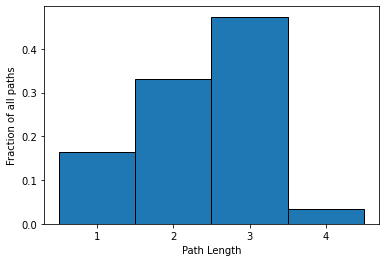

In [ ]:
plt.hist(shortest_paths_sequence, bins=range(1,6), density=True, 
         edgecolor='black', linewidth=1, align='left')
plt.xlabel('Path Length')
plt.ylabel('Fraction of all paths')
plt.xticks(range(1,5))
plt.show()

## Rozkład pośrednictwa


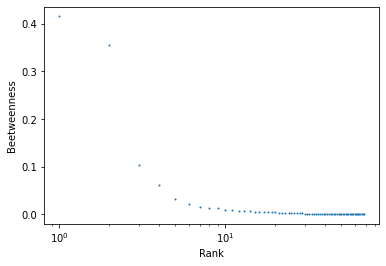

In [ ]:
betweenness_centrality = nx.betweenness_centrality(BD)
betweenness_sequence = [b for n, b in betweenness_centrality.items()]

plt.semilogx(range(1,BD.order()+1), sorted(betweenness_sequence, reverse=True), '.', markersize=2)
plt.xlabel('Rank')
plt.ylabel('Beetweenness')
plt.show()

In [ ]:
sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]

[('Vertebrate Det.', 0.4151438544292948),
 ('Ter. Invertebrates', 0.35586859817631966),
 ('Liable Det.', 0.1024136282621902),
 ('Refractory Det.', 0.06016529518857178),
 ('Snakes', 0.03121616317579177),
 ('Aquatic Invertebrates', 0.021539176701600448),
 ('Small Fish, prim. carniv', 0.013913445634426121),
 ('Small Fish, herb + omniv', 0.013816876651065799),
 ('Other herons', 0.013569390488940607),
 ('Mink', 0.00834715956573348)]

Największymi wartościami pośrednictwa cechują się elementy ekosystemu, które są odpowiedzialne za transfer energii z powrotem na najniższy poziom troficzny - są to różnego rodzaju szczątki zwierzęce, a także bezkręgowce.

## Rozkład lokalnych współczynników grupowania


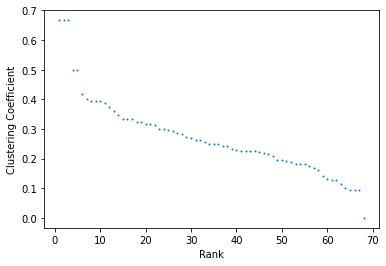

In [ ]:
clustering_coeff = nx.clustering(BD)
clustering_coeff_sequence = [c for n, c in clustering_coeff.items()]

plt.plot(range(1,BD.order()+1), sorted(clustering_coeff_sequence, reverse=True), '.', markersize=2)
plt.xlabel('Rank')
plt.ylabel('Clustering Coefficient')
plt.show()

In [ ]:
sorted(clustering_coeff.items(), key=lambda x: x[1], reverse=True)[:10]

[('Cypress Wood', 0.6666666666666666),
 ('HW Wood', 0.6666666666666666),
 ('Roots', 0.6666666666666666),
 ('Caprimulgiformes', 0.5),
 ('Bats', 0.5),
 ('Epiphytes', 0.4166666666666667),
 ('Salamanders', 0.4021164021164021),
 ('Living POC', 0.39473684210526316),
 ('Living sediment', 0.39473684210526316),
 ('Shrews', 0.39285714285714285)]

Największym lokalnym współczynnikiem grupowania charakteryzują się elementy, które nie należą do głównego silnie spójnego komponentu - takie elementy mają ograniczony rozmiar sąsiedztwa, dzięki czemu są w stanie osiągnąć wysokie wartości lokalnego współczynnika grupowania.

## Podział sieci na moduły

Analizowana sieć jest scentralizowana, wierzchołki znajdują się blisko siebie, a średnia wartość pośrednictwa jest niska. 

Taki stan rzeczy odbił się istotnie na wyznaczaniu modułów w grafie. Przetestowaliśmy kilka możliwości i wybraliśmy taką, która zwracała interpretowalne rezultaty, mimo tego, że prawdopodobnie nie jest najlepszą metodą.

Pozostałe metody dzieliły sieć na dwie społecznści o licznościach N-1 i 1.

In [ ]:
%%time
communities = list(nx.community._naive_greedy_modularity_communities(BD))

# communities = list(nx.community.girvan_newman(BD))[0]

# communities = list(nx.community.label_propagation_communities(BD)) 
# communities = list(nx.community.greedy_modularity_communities(BD, weight=None))

CPU times: user 52.9 s, sys: 124 ms, total: 53 s
Wall time: 53.1 s


Sieć została podzielona na 3 moduły. Pierwszy zawiera znaczną większość wierzchołków, a pozostałe skupiają po około 10 wierzchołków.

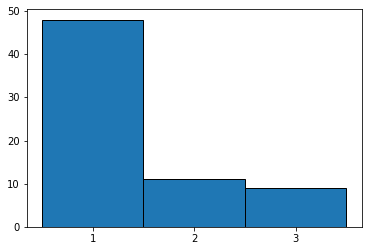

In [ ]:
community_sizes_sequence = list(map(len, communities))
plt.bar(range(1,len(communities)+1), community_sizes_sequence, width=1, align='center', edgecolor='black', linewidth=1)
plt.xticks(range(1,len(communities)+1))
plt.show()

In [ ]:
# inspect communities
cm1, cm2, cm3 = tuple(sorted(communities, key=len))

In [ ]:
list(cm1)

['Prawn',
 'Crayfish',
 'Aquatic Invertebrates',
 'Phytoplankton',
 'Living sediment',
 'Living POC',
 'Periphyton/Macroalgae',
 'Apple Snail',
 'Liable Det.']

Pierwsza społeczność zawiera wierzchołki reprezentujące elementy ekosystemu związane głownie z życiem wodnym (Kraby, Krewetki, Ślimaki, Algi, Bęzkręgowce itp.). 

In [ ]:
list(cm2)

['Float. vegetation',
 'Rabbits',
 'Cypress Leaves',
 'Squirrels',
 'Macrophytes',
 'Bobcat',
 'Understory',
 'Cypress Wood',
 'White-Tailed Deer',
 'Refractory Det.',
 'Hardwoods Leaves']

Druga społeczność zawiera głównie elementy związane z roślinnością (w tym wodną) i lasem (liście, drewno), a także zwierzęta roślinożerne (wiewiórki, króliki).

Ostatnia społeczność zawiera pozostałe elementy ekosystemu.

# Szczegółowa analiza sieci

W tej sekcji, przeprowadzimy szczegółową analizę ekosystemu Florydy. Chcemy też uzyskać odpowiedzi na następujące pytania:

1. Czy na podstawie tylko znajomości nawyków żywieniowych organizmów można je pogrupować?
2. Który element ekosystemu Florydy jest najważniejszy/najwyżej w hierarchii? Którego zwierzęcia trzeba się najbardziej bać? 




In [ ]:
# zestaw kolorów "Set1" z color-brewer
color_list = [
              '#e41a1c', # red
              '#377eb8', # blue
              '#4daf4a', # green
              '#984ea3', # purple
              '#ff7f00', # orange
              '#ffff33', # yellow
              '#a65628', # brown
              '#f781bf', # pink
]

## Wizualizacja społeczności

Poniższy graf przedstawia wyznaczone społeczności, uzyskane w trakcie wcześniejszej analizy. 

Wielkość wierzchołków zależna jest od sumy wag wszystkich krawędzi wchodzących do danego wierzchołka (suma przekazywanej do niego energii).

In [ ]:
node_size_energy_intake = dict(map(lambda x: (x[0], 10+100*np.log10(1+x[1]*1000)), BD.in_degree(weight='weight')))

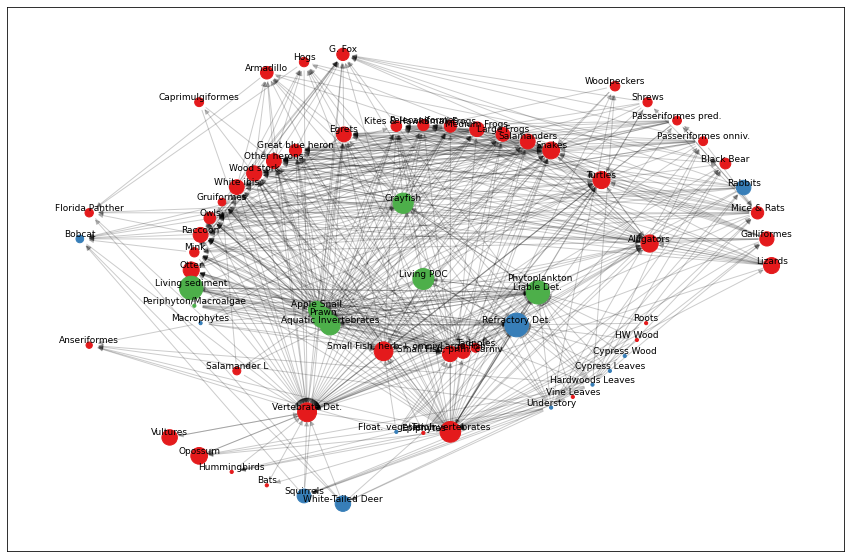

In [ ]:
plt.figure(figsize=(15,10))
pos = nx.nx_pydot.graphviz_layout(BD, prog='twopi')
for i, community in enumerate(communities):
  sizes = [node_size_energy_intake[c] for c in community]
  nx.draw_networkx_nodes(BD, pos=pos, nodelist=community, node_size=sizes, node_color=color_list[i])
nx.draw_networkx_edges(BD, pos=pos, alpha=0.2)
nx.draw_networkx_labels(BD, pos=pos, font_size=9, verticalalignment='bottom')
plt.show()

Wyznaczone społęczności w grafie nie są satysfakcjonujące. Ciągle pozostaje jeden duży komponent (oznaczony kolorem czerwonym) który zawiera elementy przynależne do różnych grup w sensie biologicznym.

W związku z tym, postanowilismy wykorzystać alternatywne do wykrywania społeczności rozwiązanie.

Prostym sposobem na podział sieci na społeczności jest kolorowanie grafu, co pozwoli pogrupować wierzchołki na podstawie wzajemnej relacji. Naturalni przeciwnicy nie trafią do tego samego modułu (będą mieli inny kolor).

Oczywiście nie jest to rozwiązanie idealne, ani dedykowane dla problemu wykrywania społeczności, niemniej może dostarczyć interesujących informacji.

In [ ]:
node_size_degree = dict(map(lambda x: (x[0], 20 + x[1]*10), BD.in_degree(weight=None)))

In [ ]:
greedy_colors = nx.greedy_color(BD)
color_communities = [[] for _ in range(max(greedy_colors.items(), key=lambda x: x[1])[1]+1)]
for n, v in greedy_colors.items():
  color_communities[v].append(n)

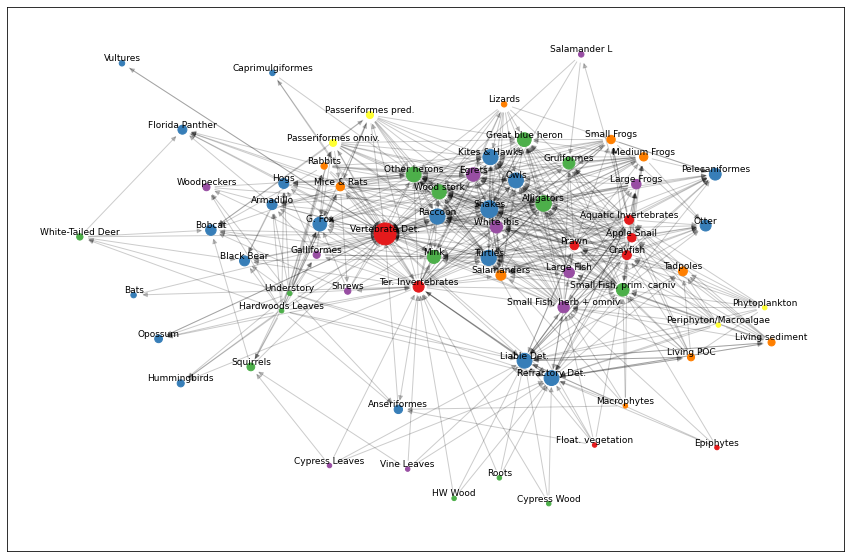

In [ ]:
plt.figure(figsize=(15,10))
pos = nx.nx_pydot.graphviz_layout(BD, prog='fdp')
for i, community in enumerate(color_communities):
  sizes = [node_size_degree[c] for c in community]
  nx.draw_networkx_nodes(BD, pos=pos, nodelist=community, node_size=sizes, node_color=color_list[i])
nx.draw_networkx_edges(BD, pos=pos, alpha=0.2)
nx.draw_networkx_labels(BD, pos=pos, font_size=9, verticalalignment='bottom')
plt.show()

Aby zweryfikować, czy wyznaczony podział nosi znamiona sensu, postanowiliśmy zweryfikować go przy użyciu wyznaczego podobieństwa między wierzchołkami (poniżej).

Podobnie żywiące się zwierzęta, np. nietoperze i ptaki z rodziny Lelkowe, mają nadany ten sam kolor, jednak podobnym do nich jaszczurkom został nadany inny kolor. Podobnie ma się sprawa w przypadku pary ryjówka, jaszczurka, a także w przyapdku pary królik, jeleń.

Z drugiej strony dostrzegamy, że zdroworozsądkowo podobne elementy ekosystemu mają nadany ten sam kolor, np. różne rodzaje drewna i liści oraz małe i średnie żaby.

Problem kolorwania grafu jest trudny obliczeniowo. Wykorzystany algorytm zachłanny prawie na pewno nie zwrócił optymalnego pokolorowania, co może wpływać na możliwości interpretacji uzyskanego rozwiązania.

In [ ]:
sim = nx.simrank_similarity(BD)
sim_top1 = [[(k,v[0],v[1]) for v in sorted(sim[k].items(), key=lambda x:x[1], reverse=True)][1] for k in sorted(sim)] 

In [ ]:
sorted(sim_top1, key=lambda x:x[2], reverse=True)[:15]

[('Bats', 'Lizards', 0.9),
 ('Caprimulgiformes', 'Lizards', 0.9),
 ('Lizards', 'Caprimulgiformes', 0.9),
 ('Shrews', 'Lizards', 0.4687678578138491),
 ('Rabbits', 'White-Tailed Deer', 0.45),
 ('White-Tailed Deer', 'Rabbits', 0.45),
 ('Passeriformes pred.', 'Shrews', 0.3495648021940069),
 ('Galliformes', 'Lizards', 0.3),
 ('Hummingbirds', 'Lizards', 0.3),
 ('Passeriformes onniv.', 'Lizards', 0.3),
 ('Woodpeckers', 'Lizards', 0.3),
 ('Medium Frogs', 'Salamander L', 0.27221743506163343),
 ('Salamander L', 'Medium Frogs', 0.27221743506163343),
 ('Small Frogs', 'Salamander L', 0.27221743506163343),
 ('Opossum', 'Lizards', 0.22757958610264792)]

## Ograniczanie wielkości grafu

Wcześniejsze próby uzyskania sensownego podziału sieci na moduły, okazały się nieudane, w związku z tym opracowalismy dwa alternatywne podejścia, które potencjalnie mogą poprawić jakość podziału sieci na moduły.

Pierwszym z proponowanych sposobów jest usunięcie krawędzi o bardzo małej wadze, w celu zmniejszenia gęstości grafu.

Drugie podejście polega na usunięciu wierzchołków reprezentujących elementy ekosystemu związane z powstawaniem szczątków zwierzęcych.

Poniższy graf przedstawia przypadek pierwszy.

W skutek usunięcia wielu krawędzi o niskiej wadze, wiele organizmów, które mają mniejszy udział energetyczny w ekosystemie, zostało odizolowanych.
W dalszym ciągu pozostał jednak jeden, centralny komponent w sieci.

W związku z odizolowaniem znacznej części wierzchołków, porzucamy dalsze analizy tej wersji grafu.

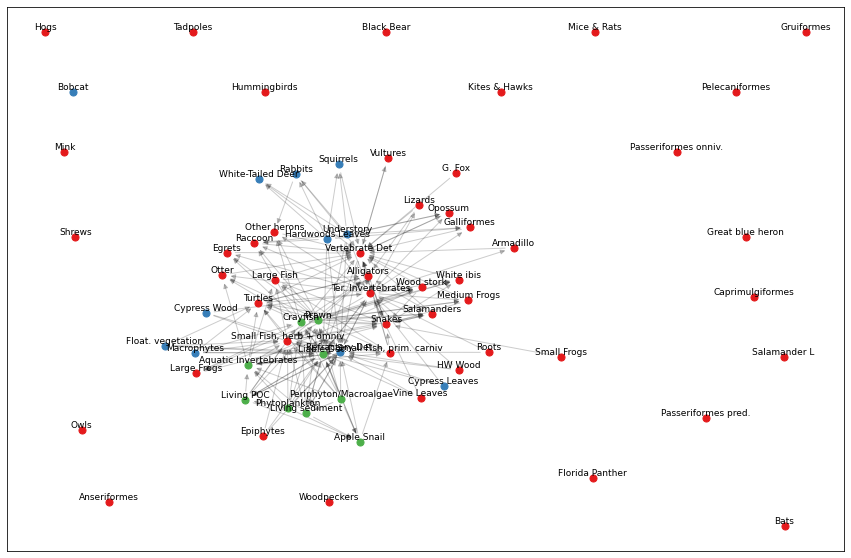

In [ ]:
plt.figure(figsize=(15,10))
pos = nx.nx_pydot.graphviz_layout(RBDv1)
for i, community in enumerate(communities):
  nx.draw_networkx_nodes(RBDv1, pos=pos, nodelist=community, node_size=50, node_color=color_list[i])
nx.draw_networkx_edges(RBDv1, pos=pos, alpha=0.2)
nx.draw_networkx_labels(RBDv1, pos=pos, font_size=9, verticalalignment='bottom')
plt.show()

Wizualizacja drugiej wersji grafu - bez szczątków roślinnych i zwierzęcych.

Szczątki stanowiły kluczową rolę w systemie wymiany energii, a ich eliminacja skutkuje usunięciem znacznej liczby krawędzi.

Dzięki temu kryterium podziału sieci na moduły wydaje się jaśniejsze. Dwie największe społeczności skupiają w sobie organizmy żyjące w wodzie lub na powierzchni. 

Na koniec można zwrócić uwagę, na unikatowe miejsce sępa w ekosystemie - w skutek usunięcia z grafu padliny - jedynego źródła pożywienia sępa - został on odizolowany od reszty wierzchołków.

In [ ]:
%%time
# redo communities detection
r_communities = list(nx.community.naive_greedy_modularity_communities(RBDv2))

CPU times: user 3min 37s, sys: 425 ms, total: 3min 37s
Wall time: 3min 37s


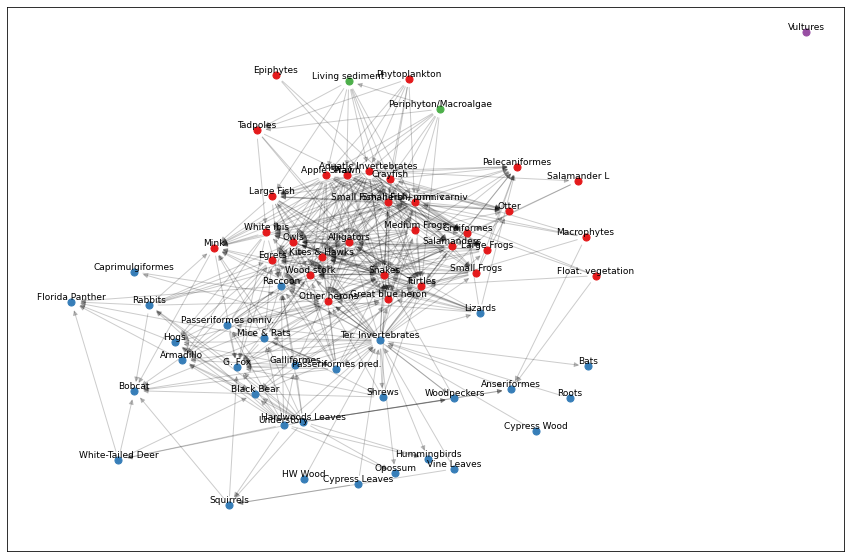

In [ ]:
plt.figure(figsize=(15,10))
pos = nx.nx_pydot.graphviz_layout(RBDv2)

for i, community in enumerate(r_communities):
  nx.draw_networkx_nodes(RBDv2, pos=pos, nodelist=community, node_size=50, node_color=color_list[i])
nx.draw_networkx_edges(RBDv2, pos=pos, alpha=0.2)
nx.draw_networkx_labels(RBDv2, pos=pos, font_size=9, verticalalignment='bottom')
plt.show()

## Padlina
Śmierć stanowi ważny element ekosystemu. Poprzednia analiza wskazała ważną rolę padliny w ekosystemie, teraz przyjrzymy się jej bliżej.

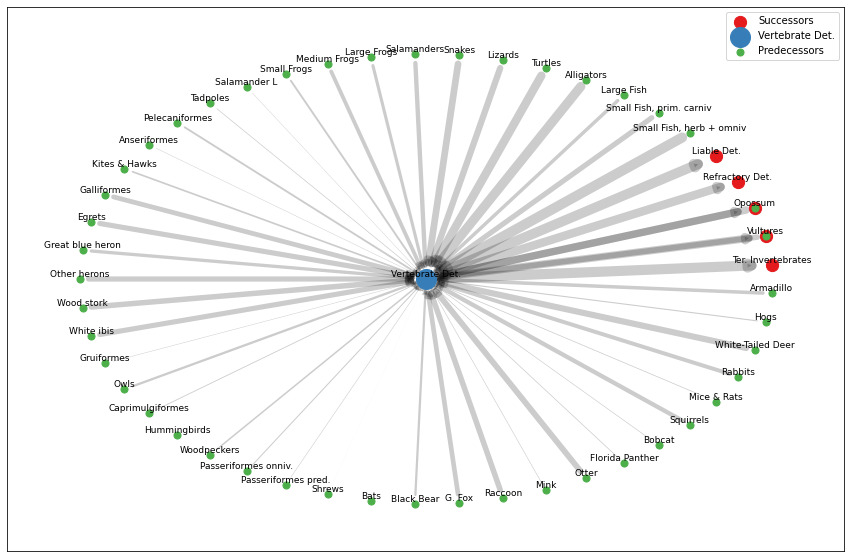

In [ ]:
subject = 'Vertebrate Det.'
s_successors = list(BD.successors(subject))
s_predecessors = list(BD.predecessors(subject))
nodes_set = set([subject] + s_successors + s_predecessors)
edges_set = set([(u,v) for u,v in BD.edges() if u == subject or v == subject])
sub_BD = nx.restricted_view(BD, 
                            nodes = [n for n in BD.nodes() if n not in nodes_set],
                            edges = [(u,v) for u,v in BD.edges() if (u,v) not in edges_set])
plt.figure(figsize=(15,10))
pos = nx.nx_pydot.graphviz_layout(sub_BD, prog='twopi', root=subject)

nx.draw_networkx_nodes(sub_BD, pos=pos, nodelist=s_successors, node_size=150, node_color=color_list[0], label='Successors')
nx.draw_networkx_nodes(sub_BD, pos=pos, nodelist=[subject], node_size=400, node_color=color_list[1], label=subject)
nx.draw_networkx_nodes(sub_BD, pos=pos, nodelist=s_predecessors, node_size=50, node_color=color_list[2], label='Predecessors')
nx.draw_networkx_edges(sub_BD, pos=pos, edgelist=None, alpha=0.2, width=[np.log2(d['weight']*1000+1) for u,v,d in sub_BD.edges.data()])
nx.draw_networkx_labels(sub_BD, pos=pos, font_size=9, verticalalignment='bottom')

plt.legend()
plt.show()

Wszystkie kręgowce zmieniają się w padlinę. Padliną żywią się oposy i sępy, lecz energię czerpią z nich także bezkręgowce ziemne. Ponadto powstaje z niej martwa materia organiczna. 

## Dieta wśród gatunków

Przypadek padliny, każe nam szerzej spojrzeć na sposób odżywiania się organizmów.

Każdy z segmentów środowiska naturalnego stanowi część systemu przekazywania energii. W tej obserwacji wyróżniamy źródła energii pochodzące od organizmów żywych (dla uproszczenia nazwane *Meat*), roślin (dla uproszczenia nazwane *Plant*) oraz martwej materii organicznej (nazywane *Detritus*).


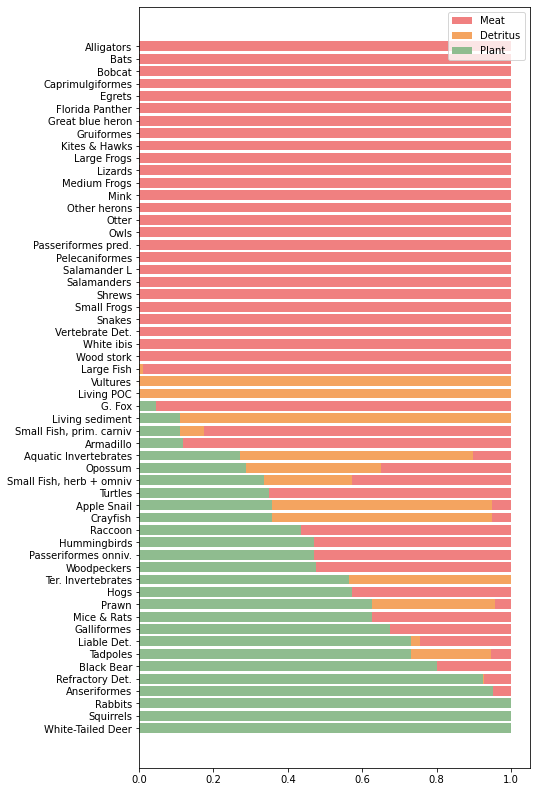

In [ ]:
detritus = [n for n in BD.nodes() if n.endswith('Det.') or n.endswith('POC')]
flora = [x for x,y in BD.nodes(data=True) if y['id'] in map(str,range(3,15))]
node_consumed_energy = dict(BD.in_degree(weight='weight'))

data = []

# iterate over all nodes
for node in BD.nodes():
  from_flora = 0.0
  from_detritus = 0.0
  from_meat = 0.0
  # itereate over predecessors of each node
  for predecessor in BD.predecessors(node):
    val = BD.edges[(predecessor, node)]['weight']
    if predecessor in flora:
      from_flora += val
    elif predecessor in detritus:
      from_detritus += val
    else:
      from_meat += val

  overall = node_consumed_energy[node]
  if overall > 0:
    data.append((node, from_flora/overall, from_detritus/overall, from_meat/overall))

df = pd.DataFrame(data, columns=['Node', 'Plant', 'Detritus', 'Meat']).sort_values(by=['Plant', 'Meat', 'Node'], ascending=[False, True, False])

fig, ax = plt.subplots(figsize=(7,14))

# not really as stacked bar chart
# first series is covered with next series, so sum of all the next series is added, to keep first series "on top"
ax.barh(df.Node, df.Plant + df.Detritus + df.Meat, label='Meat', color='lightcoral')
ax.barh(df.Node, df.Plant + df.Detritus, label='Detritus', color='sandybrown')
ax.barh(df.Node, df.Plant, label='Plant', color='darkseagreen')

ax.legend()

plt.show()

W analizowanym ekosystemie zauważyć można znaczną przewagę mięsożerców. Najmniejsze z organizmów żywią się detrytem, lecz pozyskują z niego energię również sępy i oposy. W pełni roślinożerne są jedynie jelenie, wiewiórki i króliki. Ciekawym przypadkiem jest niedźwiedź czarny, którego dieta w 80% składa się z roślin.

## Król Florydy

Poprzednie analizy wskazały, że znacząca większość organizmów ekosystemu Florydy jest przynajmniej po części mięsożerna. W tej sekcji postaramy się znaleźć zwierzę, nazywane roboczo "Królem Florydy", innymi słowy chcemy sprawdzić, które ze zwierząt jest najgorźniejsze.

Dokonanmy tej analizy na dwa sposoby:
1. Wykorzystamy algorytm PageRank, w celu sprwadzenia, który z wierzchołków akumuluje najwięcej energii.
2. Wykorzystujac poziomy troficzne, dowiemy się, które z elementów ekosystemu znajdują się najwyżej w hierarchii.

### PageRank

Wartości PageRank zosały wyznaczone dla wszystkich wierchołków w grafie, używając ważonej wersji algorytmu. Uzyskane wyniki wskazują, że najwięcej energii kumuluje się w żyjącym osadzie, czyli różnego rodzaju mikroorganizmach znajdujących się w wodzie. Nastepne w kolejności są różnego rodzaju szczątki zwierzęce.

Jeśli chodzi o duże zwierzęta, najwyżej w rankingu znalazły się węże i aligatory, ale wyznaczone dla nich wartości PR są niewielkie.

In [ ]:
pr = nx.pagerank(BD, max_iter=1000)
print('Weighted')
[(k, v) for k, v in sorted(pr.items(), key=lambda item: item[1], reverse=True)][:10]

Weighted


[('Living sediment', 0.2588010674012267),
 ('Liable Det.', 0.22777010015066135),
 ('Refractory Det.', 0.1149999767118814),
 ('Vertebrate Det.', 0.10150570999862978),
 ('Ter. Invertebrates', 0.047035634334252466),
 ('Living POC', 0.02267191298491168),
 ('Snakes', 0.016874858728567164),
 ('Alligators', 0.014306910319183625),
 ('Crayfish', 0.011482991569731427),
 ('Prawn', 0.010413436352327795)]

Powyższy ranking ponownie podkreśla, jak istotną rolę w ekosystemie pełni padlina i inne reduktory. 

Zdecydowaliśmy się ponowić eksperyment, wykorzystując graf bez wierzchołków reprezentujących szczątki organiczne. Takie działanie ma na celu "przerwanie" cyklu ekosystemu, dzięki czemu powinno udać się uzyskać dominujaće drapieżniki.

In [ ]:
# na grafie bez szczątków roślinnych i zwierzęcych
pr = nx.pagerank(RBDv2, max_iter=1000)
print('Weighted')
[(k, v) for k, v in sorted(pr.items(), key=lambda item: item[1], reverse=True)][:10]

Weighted


[('Alligators', 0.22881250210825302),
 ('Snakes', 0.19640249603845364),
 ('Turtles', 0.11223374291154864),
 ('G. Fox', 0.032460018867266946),
 ('White ibis', 0.031994347775870915),
 ('Ter. Invertebrates', 0.026279727775347404),
 ('Florida Panther', 0.022865824740762073),
 ('Wood stork', 0.019959626354504524),
 ('Other herons', 0.019054609962744246),
 ('Salamanders', 0.018071776332847178)]

Powyższy ranking wskazuje, że jeśli w analizie nie uwzględnimy padliny i innego rodzaju szczątków, najwięcej energii kumulują aligatory i węże, czyli potencjalnie najgroźniejsze drapieżniki cyprysowego rezerwatu Florydy.

### Poziom troficzny

Poziomy troficzne wykorzysytywane są w biologii, do określiania roli organizmów w przepływie energii w ekosystemie. Chcemy wykorzystać tę wiedzę, do znalezienia potencjalnie najgroźniejszych drapieżników.

Poziom troficzny wierzchołka $i$ liczy się ze wzoru 

$s_i=1+ \frac{1}{k^{in} _i} \sum _j a_{ij}s_j$

gdzie $ {k^{in} _i} $ jest stopniem wejściowym wierzchołka $i$

Podobnie jak w przypadku PR, pierwszą analizę wykonaliśmy dla całego grafu. Tym razem na szczycie hierarchii znalazł się sęp, a zaraz za nim padlina. Następne w kolejnosci są inne drapieżniki takie jak aligatory i sępy.

Wygląda na to, że padlinie udało się "oszukać" poziomy troficzne - miejsce padliny w grafie reprezentującym ekosystem wskazuje, że żywi się ona na wszystkich zwierzętach, przyjmując rolę największego drapieżnika w systemie. Oczywiście po sępie, który żywi się jedynie padliną, przez co znajduje się jeszcze ponad nią.

In [ ]:
tl = nx.trophic_levels(BD)
print('Trophic levels')
[(k, v) for k, v in sorted(tl.items(), key=lambda item: item[1], reverse=True)][:10]

Trophic levels


[('Vultures', 5.856202215485922),
 ('Vertebrate Det.', 4.856202215485922),
 ('Snakes', 4.755586712960468),
 ('Alligators', 4.683783466537001),
 ('White ibis', 4.5240672389585574),
 ('Salamander L', 4.336268316016106),
 ('Large Fish', 4.3007398104538375),
 ('Salamanders', 4.276324947014774),
 ('Pelecaniformes', 4.258896171637571),
 ('Kites & Hawks', 4.229101135404998)]

Poniższa wizualizacja przedstawia graf, w którym wielkość wierchołka zależna jest od jego poziomu troficznego, a pozostałe wierzchołki skupiają się dookoła padliny. Wyrażnie widać, że wartość poziomu troficznego wierzchołków zmniejsza się, wraz z oddalaniem się od wierzchołków o wysokim poziomie.

In [ ]:
node_size_trophic_level = dict([(k, 2**(1.6*v)) for k, v in nx.trophic_levels(BD).items()])

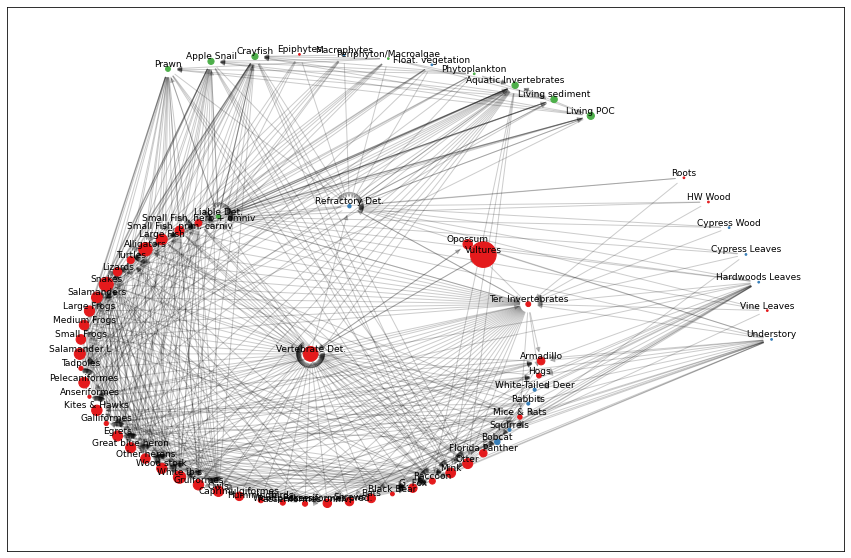

In [ ]:
plt.figure(figsize=(15,10))
pos = nx.nx_pydot.graphviz_layout(BD, prog='twopi', root='Vertebrate Det.')
for i, community in enumerate(communities):
  sizes = [node_size_trophic_level[c] for c in community]
  nx.draw_networkx_nodes(BD, pos=pos, nodelist=community, node_size=sizes, node_color=color_list[i])
nx.draw_networkx_edges(BD, pos=pos, alpha=0.2)
nx.draw_networkx_labels(BD, pos=pos, font_size=9, verticalalignment='bottom')
plt.show()

Eksperyment został ponowiony, ponownie wykorzystując graf nie zwierający padliny i innych szczątków zwierzęcych.

Gdy w grafie nie ma detrytu, sęp traci pozycję lidera i zajmuje ostatnie miejsce. Reszta rankingu wygląda prawie bez zmian.

In [ ]:
tl = nx.trophic_levels(RBDv2)
print('Trophic levels')
[(k, v) for k, v in sorted(tl.items(), key=lambda item: item[1], reverse=True)][:10]

Trophic levels


[('Snakes', 3.90033209246882),
 ('Alligators', 3.879459333129965),
 ('White ibis', 3.5821093436108824),
 ('G. Fox', 3.403018640424407),
 ('Large Fish', 3.3975840090616494),
 ('Florida Panther', 3.345708624988234),
 ('Salamanders', 3.3373815162140943),
 ('Pelecaniformes', 3.2969136652781423),
 ('Kites & Hawks', 3.2792652231049955),
 ('Owls', 3.2788805908856093)]

# Podsumowanie

W trakcie analizy, zbadaliśmy ekosystem Florydy. Jednocześnie uzyskaliśmy odpowiedzi na postawione pytania.

Wykorzystując zależności między elementami ekosystemu, udało nam się znaleźć sposób podziału na grupy, który dzieli te elementy w zależności od sposobu egzystencji danych elementów (środowisko wodne, a środowisko leśne).

W kolejnych krokach przeanalizowaliśmy sposoby żywienia się organizmów, po czym wyznaczyliśmy najbardziej niebezpieczne ze stworzeń zamieszkujących cyprysowe bagna Florydy, badając przepływ energii w ekosystemie.